# Applying SHRED to the C. elegan Dataset 

Data obtained from Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans. Cell, 163(3), 656–669. http://doi.org/10.1016/j.cell.2015.09.034

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

**Experiment 4: Differen train test splits**
- randomly select three neurons from the high variance group


In [1]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge
from visualizations import *


hello


In [2]:
#Importing packages

os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.chdir("../") 
os.chdir("/home/amy/SHRED_neuro/shred")
from processdata_shred import load_data as load_data_shred
from processdata_shred import TimeSeriesDataset as TimeSeriesDataset_shred
import models_shred


# Change into the directory
os.chdir("/home/amy/SHRED_neuro/sindy-shred") ## Change to where the repo was cloned

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Data Format
- 5 worms
- 18 mins at roughly 2.85 samples per second --> ~3000 samples per trial
- 107 - 131 neurons

*Worm One, No Stim*

In [3]:
# Loading the Dataset
# os.chdir("../")
os.chdir("../")

data_path = 'worms/worm_data/WT_Stim.mat'
data = loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AVA_HisCl', 'WT_NoStim', 'WT_Stim'])


In [4]:
# Working with the no stim condition -- WORM ONE
neuron = 0
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
print(neuron_data.shape)
time = no_stim[0][neuron][4]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = no_stim[0][neuron][6][0][0]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m) number neurons(n):', m,n)
print('sr', sr, 'Hz')



neuron_one = neuron_data_cor[:1500,:]
time_one = time[:1500].flatten()
neuron_name_one = np.array(neuron_name)
dt_one = time[1][0] - time[0][0]


(3137, 109)
number timepoints(m) number neurons(n): 3137 109
sr 2.9046296296296297 Hz


Studying the variance of the neuronal activity

In [12]:
######## NEURON ONE
# Splitting into high and low variance groups
load_X = neuron_one
name = "one"
dt = dt_one
print(load_X.shape)

n_t = load_X.shape[0] # number of timepoints
n_s = load_X.shape[1] #number of neurons 
num_neurons = 3 
lags = 50

latent_dim = 64
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred

var = np.std(load_X, axis = 0)
var_ave = np.mean(var)
neuron_index = np.arange(var.shape[0])
high_ind = np.where(var > var_ave)[0]
low_ind = np.where(var < var_ave)[0]

# Randomly select the neurons to train the SHRED model on
indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
neuron_locations = high_ind[indices]
file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_4/neuron_loc_{name}.npy"
np.save(file_path, neuron_locations)

train_test_split = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for k in range(8):
    test_val_size = int(n_t* train_test_split[k]) 
    train_indices = np.arange(0, n_t - lags - test_val_size)
    mask = np.ones(n_t - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[int(test_val_size/2): test_val_size]
    test_indices = valid_test_indices[:int(test_val_size/2)]

    for z in range(5):

        sc = MinMaxScaler()
        sc = sc.fit(load_X[train_indices])
        transformed_X = sc.transform(load_X)

        ### Generate input sequences to a SHRED model
        all_data_in = np.zeros((n_t - lags, lags, num_neurons))
        for i in range(len(all_data_in)):
            all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

        ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
        valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
        test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

        ### -1 to have output be at the same time as final sensor measurements
        train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
        valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
        test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

        train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
        valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
        test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

        shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                        library_dim=library_dim, poly_order=poly_order,
                                        include_sine=include_sine, dt=dt, layer_norm=False).to(device)

        validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                            lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                            optimizer="AdamW", thres_epoch=100)

        test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
        test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
        mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
        print('mse test', mse_test)
        train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
        train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
        mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
        print('mse train', mse_train)

        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_4/train_recon_split{k}_{z}.npy"
        np.save(file_path, train_recons)

        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_4/test_recon_split{k}_{z}.npy"
        np.save(file_path, test_recons)


        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_4/train_gt_split{k}_{z}.npy"
        np.save(file_path, train_ground_truth)

        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_4/test_gt_split{k}_{z}.npy"
        np.save(file_path, test_ground_truth)




(1500, 109)
1 : tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0362, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0348, d

**Importing the Data**

In [13]:
n_trials = 5

[0 1 2 3 4]
0
1
2
3
4
5
6
7


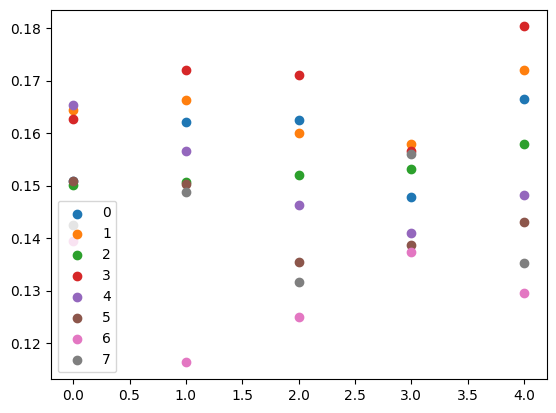

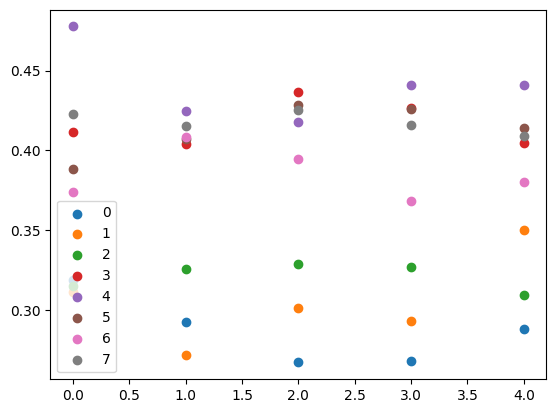

In [27]:
split = np.arange(0,8)
trial = np.arange(0,5)

print(trial)
train_mse = {}
test_mse = {}

for i in range(len(split)):
    train_mse[split[i]] = []
    test_mse[split[i]] = []
    print(split[i])
    for k in range(n_trials):
        train_gt = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_4/train_gt_split{split[i]}_{k}.npy")
        train_recon = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_4/train_recon_split{split[i]}_{k}.npy")
        mse_train = np.linalg.norm(train_recon - train_gt) / np.linalg.norm(train_gt)
      
        test_gt = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_4/test_gt_split{split[i]}_{k}.npy")
        test_recon = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_4/test_recon_split{split[i]}_{k}.npy")
        mse_test = np.linalg.norm(test_recon - test_gt) / np.linalg.norm(test_gt)
        
        train_mse[split[i]].append(mse_train)
        test_mse[split[i]].append(mse_test)

for z in range(len(split)):
    plt.scatter(np.arange(n_trials),train_mse[split[z]], label = f"{split[z]}")
plt.legend()
plt.show()


for z in range(len(split)):
    plt.scatter(np.arange(n_trials),test_mse[split[z]], label = f"{split[z]}")
plt.legend()

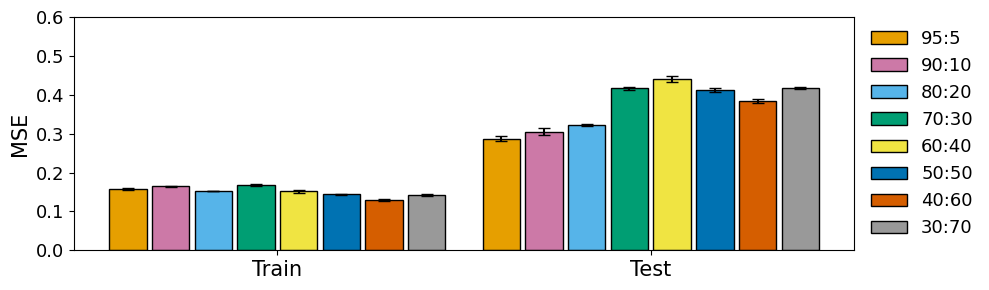

In [66]:
mean_one = [np.mean(train_mse[split[0]]), np.mean(test_mse[split[0]])]
mean_two = [np.mean(train_mse[split[1]]), np.mean(test_mse[split[1]])]
mean_three = [np.mean(train_mse[split[2]]), np.mean(test_mse[split[2]])]
mean_four = [np.mean(train_mse[split[3]]), np.mean(test_mse[split[3]])]
mean_five = [np.mean(train_mse[split[4]]), np.mean(test_mse[split[4]])]
mean_six = [np.mean(train_mse[split[5]]), np.mean(test_mse[split[5]])]
mean_seven = [np.mean(train_mse[split[6]]), np.mean(test_mse[split[6]])]
mean_eight = [np.mean(train_mse[split[7]]), np.mean(test_mse[split[7]])]


std_one = [np.std(train_mse[split[0]])/np.sqrt(8), np.std(test_mse[split[0]])/np.sqrt(8)]
std_two = [np.std(train_mse[split[1]])/np.sqrt(8), np.std(test_mse[split[1]])/np.sqrt(8)]
std_three = [np.std(train_mse[split[2]])/np.sqrt(8), np.std(test_mse[split[2]])/np.sqrt(8)]
std_four = [np.std(train_mse[split[3]])/np.sqrt(8), np.std(test_mse[split[3]])/np.sqrt(8)]
std_five = [np.std(train_mse[split[4]])/np.sqrt(8), np.std(test_mse[split[4]])/np.sqrt(8)]
std_six = [np.std(train_mse[split[5]])/np.sqrt(8), np.std(test_mse[split[5]])/np.sqrt(8)]
std_seven = [np.std(train_mse[split[6]])/np.sqrt(8), np.std(test_mse[split[6]])/np.sqrt(8)]
std_eight = [np.std(train_mse[split[7]])/np.sqrt(8), np.std(test_mse[split[7]])/np.sqrt(8)]


x = np.arange(len(mean_one))
labels = ['Train', 'Test']


train_test_split = ["95:5", "90:10", "80:20", "70:30", "60:40", "50:50", "40:60", "30:70"]

colors = [
    "#E69F00",  # orange
    "#CC79A7",  # reddish purple
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#999999"   # gray
]

bar_width = 0.1
offsets = np.linspace(-bar_width*4, bar_width*4, 8)  

fig, ax = plt.subplots(figsize=(10, 3))

ax.bar(x + offsets[0], mean_one,   yerr=std_one,   capsize=4, width=bar_width, color=colors[0], edgecolor='black', label='Group 1')
ax.bar(x + offsets[1], mean_two,   yerr=std_two,   capsize=4, width=bar_width, color=colors[1], edgecolor='black', label='Group 2')
ax.bar(x + offsets[2], mean_three, yerr=std_three, capsize=4, width=bar_width, color=colors[2], edgecolor='black', label='Group 3')
ax.bar(x + offsets[3], mean_four,  yerr=std_four,  capsize=4, width=bar_width, color=colors[3], edgecolor='black', label='Group 4')
ax.bar(x + offsets[4], mean_five,  yerr=std_five,  capsize=4, width=bar_width, color=colors[4], edgecolor='black', label='Group 5')
ax.bar(x + offsets[5], mean_six,   yerr=std_six,   capsize=4, width=bar_width, color=colors[5], edgecolor='black', label='Group 6')
ax.bar(x + offsets[6], mean_seven, yerr=std_seven, capsize=4, width=bar_width, color=colors[6], edgecolor='black', label='Group 7')
ax.bar(x + offsets[7], mean_eight, yerr=std_eight, capsize=4, width=bar_width, color=colors[7], edgecolor='black', label='Group 8')


# Customize ticks and labels
ax.set_xticks(x)
ax.tick_params(axis='y', labelsize=13)
ax.set_ylim((0,0.6))
ax.set_xticklabels(labels, fontsize = 15)
ax.set_ylabel("MSE", fontsize = 15)
plt.legend(train_test_split,loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize = 13)

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/mse_bar_split.png", transparent=True, dpi=500)

plt.show()

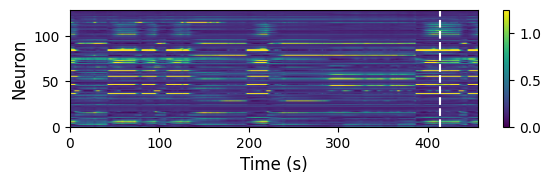

(1200, 129)
(129, 1325)


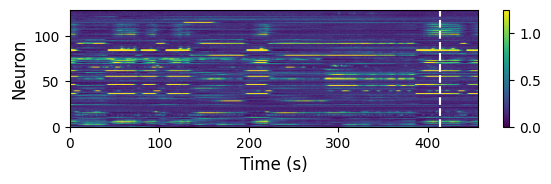

In [31]:
name = "five"
train = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_2/train_recon_{name}.npy")
test = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_2/test_recon_{name}.npy")
data = np.vstack((train, test)).T
time = time_one[:data.shape[1]]
plt.figure(figsize = (6,2))
plt.imshow(data, aspect = "auto", extent = [0, time[-1],0,data.shape[0]], vmin = 0, vmax = 1.25)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Neuron', fontsize =12)
plt.axvline(time[train.shape[0]], color = 'white', linestyle = '--')
plt.colorbar()
plt.tight_layout()
plt.savefig(f"/home/amy/SHRED_neuro/worms/data_output/figs/{name}_recon.png", transparent = True, dpi = 400)

plt.show()

print(train.shape)
print(data.shape)

train = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_2/train_gt_{name}.npy")
test = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_2/test_gt_{name}.npy")
data = np.vstack((train, test)).T
time = time_one[:data.shape[1]]
plt.figure(figsize = (6,2))
plt.imshow(data, aspect = "auto", extent = [0, time[-1],0,data.shape[0]], vmin = 0, vmax = 1.25)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Neuron', fontsize = 12)
plt.colorbar()
plt.axvline(time[train.shape[0]], color = 'white', linestyle = '--')
plt.tight_layout()
plt.savefig(f"/home/amy/SHRED_neuro/worms/data_output/figs/{name}_gt.png", transparent = True, dpi = 400)
plt.show()

**Example: select 3 randomly from high variance**

In [13]:


# Randomly select the neurons to train the SHRED model on
indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
neuron_locations = high_ind[indices]

#Plotting the Carpet plot
plt.figure(figsize = (5,3))
plt.imshow(load_X.T, aspect = 'auto', extent=[time[0], time[-1], n_s,0])

plt.xlabel('Time', fontsize = 14)
plt.ylabel('Neurons',fontsize = 14)

for i in range(neuron_locations.shape[0]):
  plt.axhline(neuron_locations[i], color = 'red')


plt.figure(figsize = (4,3))
plt.plot(time, load_X[:,neuron_locations])
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Neurons', fontsize = 14)




NameError: name 'high_ind' is not defined

In [137]:
test_val_size = 2000 - lags
train_indices = np.arange(0, n_t - lags - test_val_size)
mask = np.ones(n_t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[:1000]
test_indices = valid_test_indices[1000:2000]


In [138]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n_t - lags, lags, num_neurons))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset_shred(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset_shred(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset_shred(test_data_in, test_data_out)

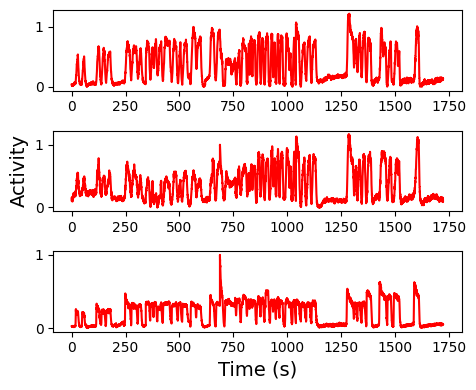

In [139]:
sub_index_X = transformed_X[:,neuron_locations]
fig, ax = plt.subplots(num_neurons, figsize = (5,4))

for i in range(num_neurons):
    ax[i].plot(time, sub_index_X[:,i], color = 'red')
plt.xlabel('Time (s)', fontsize = 14)
ax[1].set_ylabel('Activity', fontsize = 14)
plt.tight_layout()


In [140]:

# Randomly select the neurons to train the SHRED model on
indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
neuron_locations = high_ind[indices]
file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/neuron_loc.npy"
np.save(file_path, neuron_locations)
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n_t - lags, lags, num_neurons))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cpu' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset_shred(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset_shred(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset_shred(test_data_in, test_data_out)
shred = models_shred.SHRED(num_neurons, n_s, hidden_size=128, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=5000, lr=1e-3, verbose=True, patience = 5)
#Mean Squared Error
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
print('MSE test', mse_test)

train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
print('MSE train', mse_train)

file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/train_recon_loc.npy"
np.save(file_path, train_recons)

file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/test_recon_loc.npy"
np.save(file_path, test_recons)


file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/train_gt_loc.npy"
np.save(file_path, train_ground_truth)

file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/test_gt_loc.npy"
np.save(file_path, test_ground_truth)
    

Training epoch 1
Error tensor(0.6229)
Training epoch 20
Error tensor(0.6353)
Training epoch 40
Error tensor(0.5968)
Training epoch 60
Error tensor(0.6335)
Training epoch 80
Error tensor(0.6428)
Training epoch 100
Error tensor(0.6316)
Training epoch 120
Error tensor(0.5899)
Training epoch 140
Error tensor(0.5927)
Training epoch 160
Error tensor(0.5981)
Training epoch 180
Error tensor(0.5988)
Training epoch 200
Error tensor(0.6123)
Training epoch 220
Error tensor(0.6299)
MSE test 0.5217875
MSE train 0.0922396


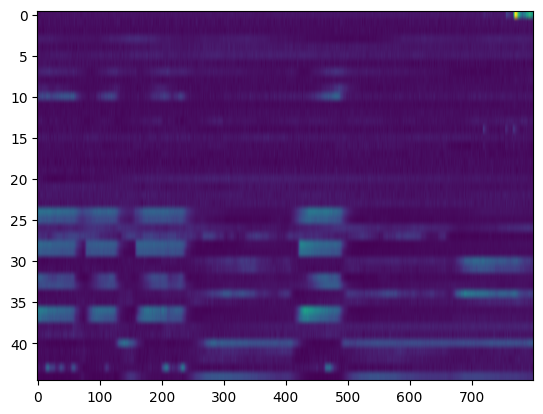

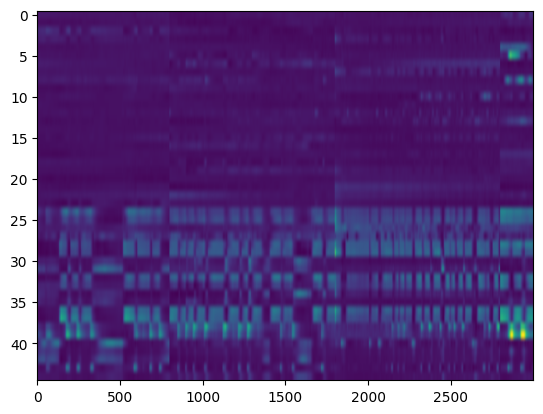

In [142]:
plt.imshow(test_ground_truth.T, aspect = 'auto')
plt.show()
plt.imshow(train_recons.T, aspect = 'auto')

In [144]:
latent_dim = 64
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred



## high variance
for k in range(1):
    # Randomly select the neurons to train the SHRED model on
    indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
    neuron_locations = high_ind[indices]
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/neuron_loc_{k}.npy"
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n_t - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, layer_norm=False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                        optimizer="AdamW", thres_epoch=100)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print('mse test', mse_test)
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
    print('mse train', mse_train)

    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/train_recon_{k}.npy"
    np.save(file_path, train_recons)

    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/test_recon_{k}.npy"
    np.save(file_path, test_recons)


    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/train_gt_{k}.npy"
    np.save(file_path, train_ground_truth)

    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_3/test_gt_{k}.npy"
    np.save(file_path, test_ground_truth)

1 : tensor(0.1914, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.1597, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0545, device='cuda:

(800, 45)
(45, 3800)


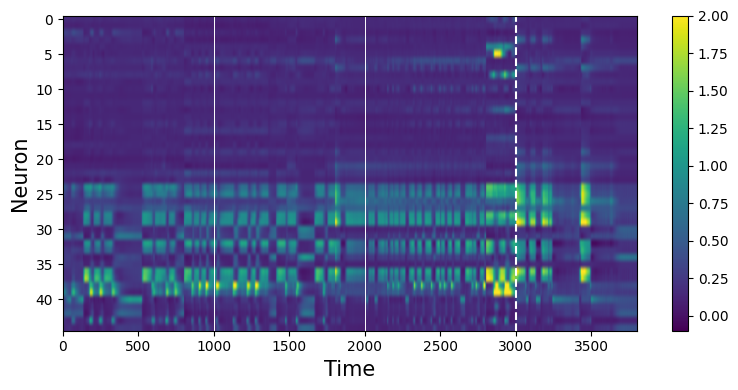

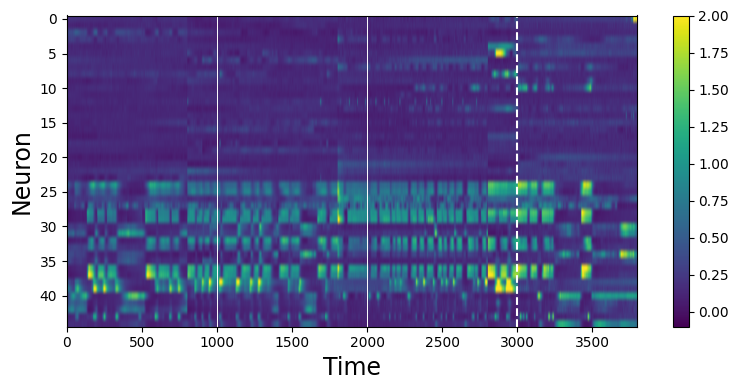

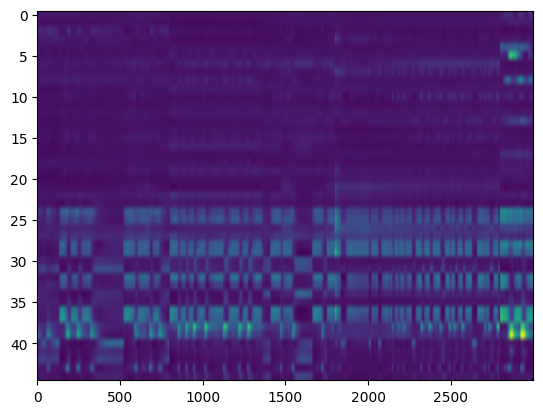

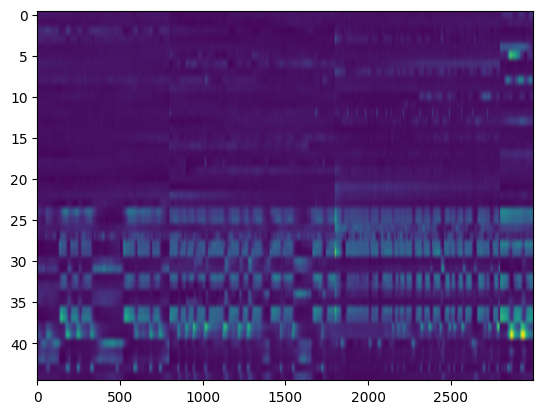

In [177]:
data_recons = np.hstack((train_recons.T, test_recons.T))
print(test_recons.shape)
print(data_recons.shape)
plt.figure(figsize = (8,4))
plt.imshow(data_recons, aspect = 'auto', vmin=-0.1, vmax=2)
plt.axvline(3000, color = 'white', linestyle = '--')
plt.axvline(1000, color = 'white', linewidth = 0.7)
plt.axvline(2000, color = 'white', linewidth = 0.7)

plt.xlabel('Time', fontsize = 15)
plt.ylabel('Neuron', fontsize = 15)
plt.colorbar()

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/exp3_recons.png", transparent=True, dpi=500)

plt.show()


data_gt = np.hstack((train_ground_truth.T, test_ground_truth.T))
plt.figure(figsize = (8,4))
plt.imshow(data_gt, aspect = 'auto', vmin=-0.1, vmax=2)
plt.axvline(3000, color = 'white', linestyle = '--')
plt.axvline(1000, color = 'white', linewidth = 0.7)
plt.axvline(2000, color = 'white', linewidth = 0.7)
plt.xlabel('Time', fontsize = 17)
plt.ylabel('Neuron', fontsize = 17)
plt.colorbar()
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/exp3_gt.png", transparent=True, dpi=500)
plt.show()

plt.imshow(train_recons.T, aspect = 'auto')
plt.show()

plt.imshow(train_ground_truth.T, aspect = 'auto')

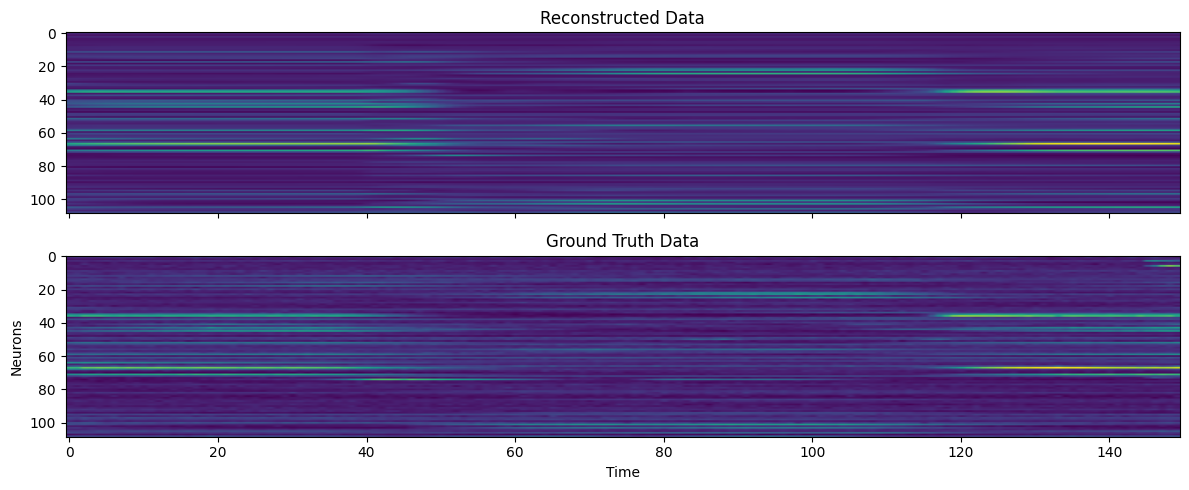

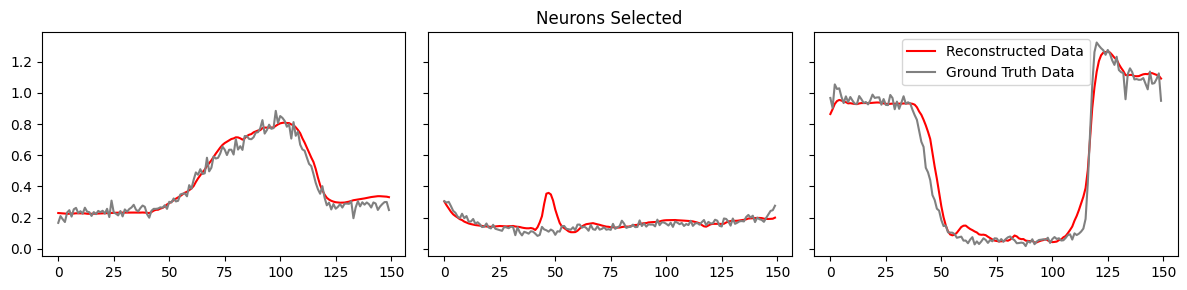

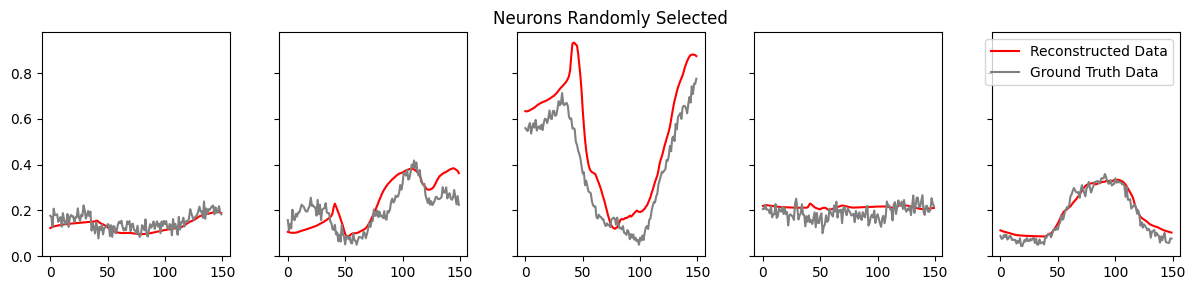

In [193]:
### Reconstructed and ground truth Carpet Plot
fig, axes = plt.subplots(2, figsize=(12, 5), sharex=True, sharey=True)
# Plot the reconstructed data
axes[0].imshow(test_recons.T, aspect='auto')
axes[0].set_title("Reconstructed Data")
# Plot the ground truth data
axes[1].imshow(test_ground_truth.T, aspect='auto')
axes[1].set_title("Ground Truth Data")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Neurons')


plt.tight_layout()
plt.show()



### Reconstructed and ground truth Activity Traces - selected neurons
fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
for i in range(num_neurons):
    axes[i].plot(test_recons[:, neuron_locations[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(test_ground_truth[:, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
    axes[1].set_title('Neurons Selected')
plt.legend()
plt.tight_layout()
plt.show()


### Reconstructed and ground truth Activity Traces - random neurons
neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axes[i].plot(test_recons[:, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(test_ground_truth[:, neuron_loc_graph[i]], label = 'Ground Truth Data', color ='grey')
    axes[2].set_title('Neurons Randomly Selected')
plt.legend()
plt.tight_layout()
plt.show()

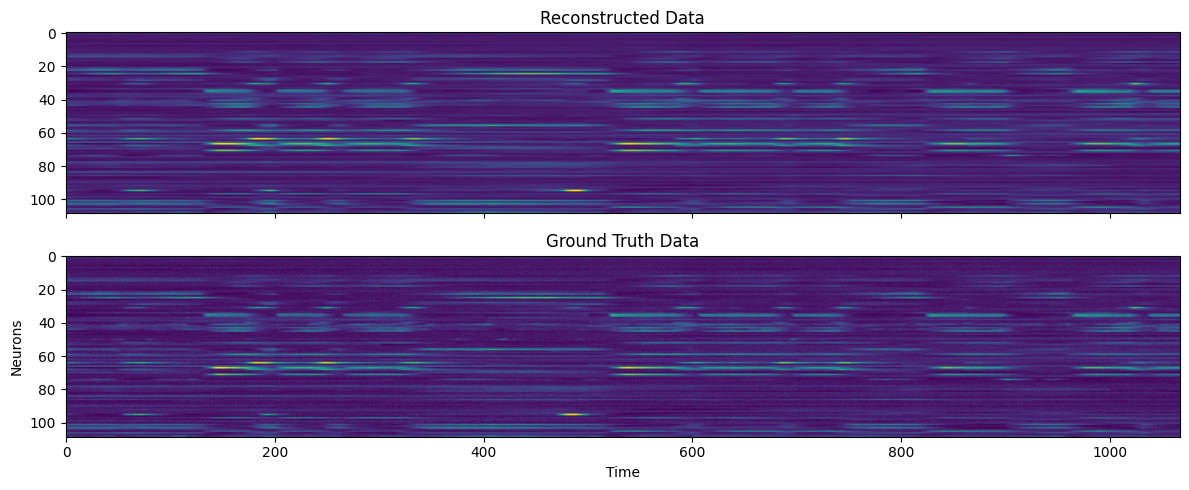

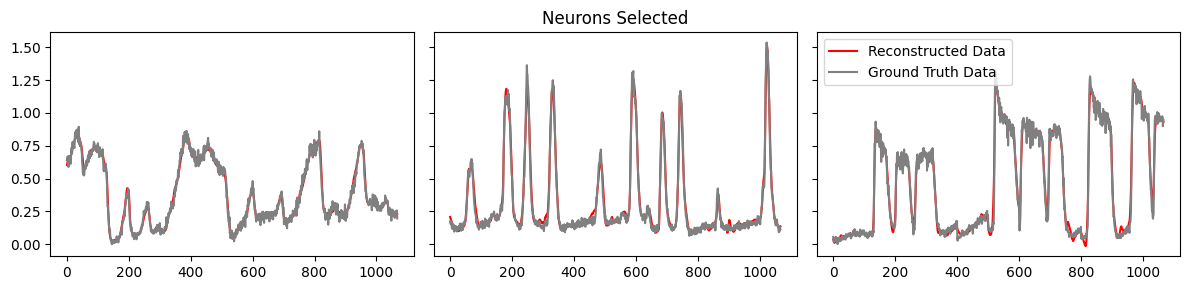

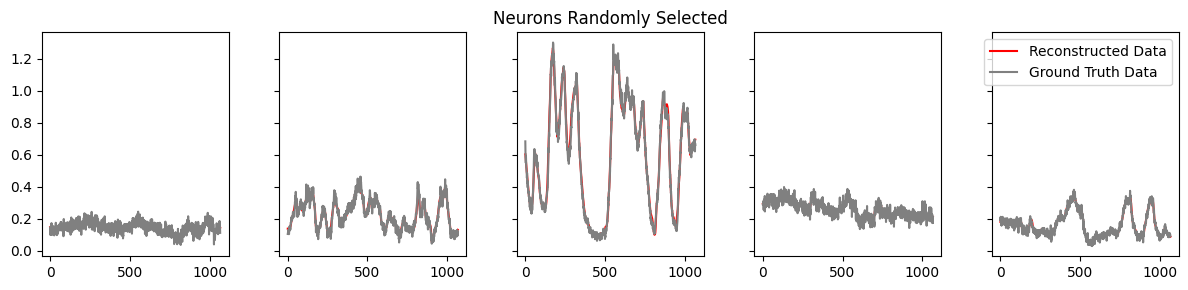

In [194]:

### Reconstructed and ground truth Carpet Plot
fig, axes = plt.subplots(2, figsize=(12, 5), sharex=True, sharey=True)
# Plot the reconstructed data
axes[0].imshow(train_recons.T, aspect='auto')
axes[0].set_title("Reconstructed Data")
# Plot the ground truth data
axes[1].imshow(train_ground_truth.T, aspect='auto')
axes[1].set_title("Ground Truth Data")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Neurons')


plt.tight_layout()
plt.show()



### Reconstructed and ground truth Activity Traces - selected neurons
fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
for i in range(num_neurons):
    axes[i].plot(train_recons[:, neuron_locations[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(train_ground_truth[:, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
    axes[1].set_title('Neurons Selected')
plt.legend()
plt.tight_layout()
plt.show()


### Reconstructed and ground truth Activity Traces - random neurons
# neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axes[i].plot(train_recons[:, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(train_ground_truth[:, neuron_loc_graph[i]], label = 'Ground Truth Data', color ='grey')
    axes[2].set_title('Neurons Randomly Selected')
plt.legend()
plt.tight_layout()
plt.show()

# High vs low variance reconstructions

In [22]:
latent_dim = 64
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred
num_neurons = 3 
lags = 200
test_val_size = 300
new_m = int(m/2)
train_indices = np.arange(0, new_m - lags - test_val_size)
mask = np.ones(new_m - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, new_m - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[:int(test_val_size/2)]
test_indices = valid_test_indices[int(test_val_size/2):test_val_size]


## high variance
for k in range(25):
    # Randomly select the neurons to train the SHRED model on
    indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
    neuron_locations = high_ind[indices]
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/neuron_loc_{k+1}.npy"
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((new_m - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, layer_norm=False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                        optimizer="AdamW", thres_epoch=100)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print('mse test', mse_test)
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
    print('mse train', mse_train)


    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/train_recon_{k+1}.npy"
    np.save(file_path, train_recons)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/test_recon_{k+1}.npy"
    np.save(file_path, test_recons)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/train_gt_{k+1}.npy"
    np.save(file_path, train_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/test_gt_{k+1}.npy"
    np.save(file_path, test_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/mse_{k+1}.npy"
    np.save(file_path, [mse_train, mse_test])





## low variance
for k in range(25):
    # Randomly select the neurons to train the SHRED model on
    indices = np.random.choice(low_ind.shape[0], size= num_neurons, replace=False) 
    neuron_locations = low_ind[indices]
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/neuron_loc_{k+1}.npy"
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((new_m - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, layer_norm=False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                        optimizer="AdamW", thres_epoch=100)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print('mse test', mse_test)
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
    print('mse train', mse_train)


    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/train_recon_{k+1}.npy"
    np.save(file_path, train_recons)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/test_recon_{k+1}.npy"
    np.save(file_path, test_recons)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/train_gt_{k+1}.npy"
    np.save(file_path, train_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/test_gt_{k+1}.npy"
    np.save(file_path, test_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/mse_{k+1}.npy"
    np.save(file_path, [mse_train, mse_test])






## random

for k in range(25):
    # Randomly select the neurons to train the SHRED model on
    neuron_locations = np.random.choice(n, size= num_neurons, replace=False) 

    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/neuron_loc_{k+1}.npy"
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((new_m - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, layer_norm=False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                        optimizer="AdamW", thres_epoch=100)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print('mse test', mse_test)
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
    print('mse train', mse_train)


    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/train_recon_{k+1}.npy"
    np.save(file_path, train_recons)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/test_recon_{k+1}.npy"
    np.save(file_path, test_recons)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/train_gt_{k+1}.npy"
    np.save(file_path, train_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/test_gt_{k+1}.npy"
    np.save(file_path, test_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/mse_{k+1}.npy"
    np.save(file_path, [mse_train, mse_test])



1 : tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0340, device='cuda:

**Loading in the data**

In [26]:
n_trials = 25

In [27]:
####### MSE
#HIGH
train_mse_high = []
test_mse_high = []
for k in range(1,26):
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/mse_{k}.npy")
    train_mse_high.append(data[0])
    test_mse_high.append(data[1])

#LOW
train_mse_low = []
test_mse_low = []
for k in range(1,26):
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/mse_{k}.npy")
    train_mse_low.append(data[0])
    test_mse_low.append(data[1])

#RANDOM
train_mse_rand = []
test_mse_rand = []
for k in range(1,26):
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/mse_{k}.npy")
    train_mse_rand.append(data[0])
    test_mse_rand.append(data[1])


In [28]:
######## Ground truth
train_gt = []
test_gt = []

for k in range(1,26):
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/train_gt_{k}.npy")
    train_gt.append(data)
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/test_gt_{k}.npy")
    test_gt.append(data)


In [29]:
######## Neurons
# HIGH
neuron_high = []
# LOW
neuron_low = []
# RANDOM
neuron_rand = []


for k in range(1,26):
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/neuron_loc_{k}.npy")
    neuron_high.append(data)

    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/neuron_loc_{k}.npy")
    neuron_low.append(data)

    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/neuron_loc_{k}.npy")
    neuron_rand.append(data)

In [30]:
######## Reconstruction
# HIGH
train_recon_high = []
test_recon_high = []

# LOW
train_recon_low = []
test_recon_low = []

# RANDOM
train_recon_rand = []
test_recon_rand = []



for k in range(1,26):
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/train_recon_{k}.npy")
    train_recon_high.append(data)
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/high/test_recon_{k}.npy")
    test_recon_high.append(data)

    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/train_recon_{k}.npy")
    train_recon_low.append(data)
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/low/test_recon_{k}.npy")
    test_recon_low.append(data)

    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/train_recon_{k}.npy")
    train_recon_rand.append(data)
    data = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_1.1/rand/test_recon_{k}.npy")
    test_recon_rand.append(data)


## Calculating the average and standard deviation
# HIGH
train_ave_high = []
test_ave_high = []
train_std_high = []
test_std_high = []

# LOW
train_ave_low = []
test_ave_low = []
train_std_low = []
test_std_low = []

# RANDOM
train_ave_rand = []
test_ave_rand = []
train_std_rand = []
test_std_rand = []


for k in range(n):
    train_ave_h = np.zeros((n_trials, train_recon_high[0].shape[0]))
    train_ave_l = np.zeros((n_trials, train_recon_high[0].shape[0]))
    train_ave_r = np.zeros((n_trials, train_recon_high[0].shape[0]))

    test_ave_h = np.zeros((n_trials, test_recon_high[0].shape[0]))
    test_ave_l = np.zeros((n_trials, test_recon_high[0].shape[0]))
    test_ave_r = np.zeros((n_trials, test_recon_high[0].shape[0]))

    for i in range(n_trials):
        train_ave_h[i,:] = train_recon_high[i][:,k]
        train_ave_l[i,:] = train_recon_low[i][:,k]
        train_ave_r[i,:] = train_recon_rand[i][:,k]

        test_ave_h[i,:] = test_recon_high[i][:,k]
        test_ave_l[i,:] = test_recon_low[i][:,k]
        test_ave_r[i,:] = test_recon_rand[i][:,k]

    train_ave_high.append(np.mean(train_ave_h, axis = 0))
    train_std_high.append(np.std(train_ave_h, axis = 0))
    test_ave_high.append(np.mean(test_ave_h, axis = 0))
    test_std_high.append(np.std(test_ave_h, axis = 0))
    
    train_ave_low.append(np.mean(train_ave_l, axis = 0))
    train_std_low.append(np.std(train_ave_l, axis = 0))
    test_ave_low.append(np.mean(test_ave_l, axis = 0))
    test_std_low.append(np.std(test_ave_l, axis = 0))

    train_ave_rand.append(np.mean(train_ave_r, axis = 0))
    train_std_rand.append(np.std(train_ave_r, axis = 0))
    test_ave_rand.append(np.mean(test_ave_r, axis = 0))
    test_std_rand.append(np.std(test_ave_r, axis = 0))


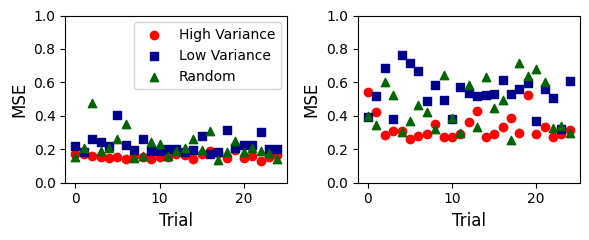

In [34]:
x = np.arange(n_trials)
fig, ax = plt.subplots(1,2, figsize = (6,2.5))
ax[0].scatter(x, train_mse_high, color = 'red', label = 'High Variance', marker = 'o')
ax[0].scatter(x, train_mse_low, color = 'darkblue', label = 'Low Variance', marker = 's')
ax[0].scatter(x, train_mse_rand, color = 'darkgreen', label = 'Random', marker = '^')
# ax[0].set_title('Training MSE')
ax[0].set_ylim([0,1])
ax[0].set_ylabel('MSE', fontsize = 12)
ax[0].set_xlabel('Trial', fontsize = 12)



ax[1].scatter(x, test_mse_high, color = 'red', label = 'High Variance', marker = 'o')
ax[1].scatter(x, test_mse_low, color = 'darkblue', label = 'Low Variance', marker = 's')
ax[1].scatter(x, test_mse_rand, color = 'darkgreen', label = 'Random', marker = '^')
ax[1].set_ylim([0,1])
ax[1].set_ylabel('MSE', fontsize = 12)
ax[1].set_xlabel('Trial', fontsize = 12)


# ax[1].set_title('Testing MSE')


ax[0].legend()
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/mse_var_scatter.png", transparent=True, dpi=500)



In [38]:
n_loc = np.random.choice(n, size = 10, replace = False)
print(n_loc)

[ 82  45 105  93  52  24  76  86  46  61]


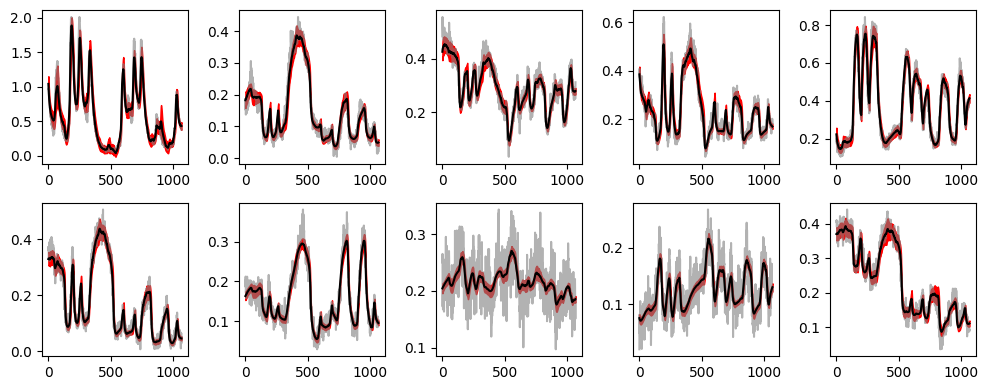

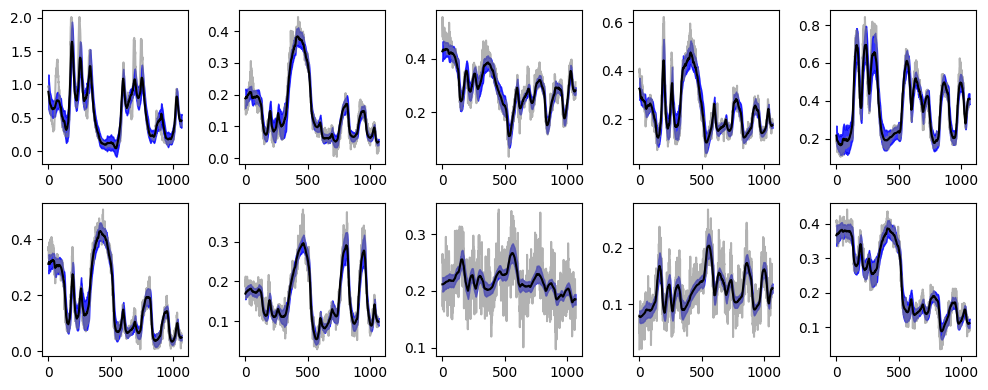

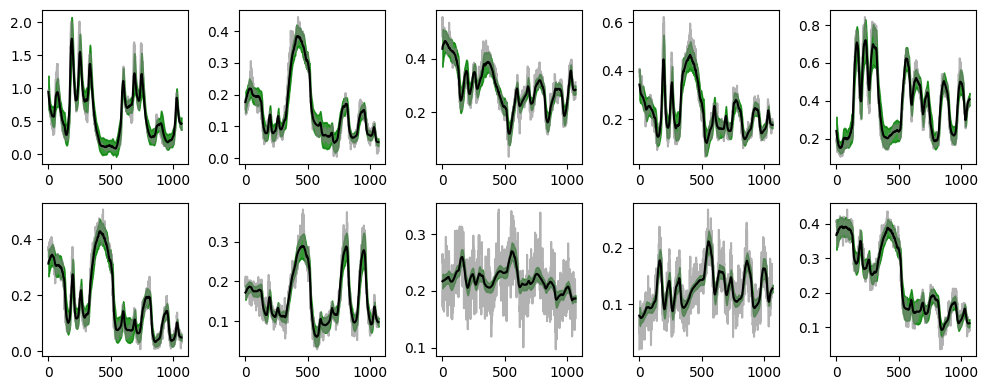

In [162]:
## Plotting ave and std TRAIN
#HIGH
fig, ax = plt.subplots(2,5, figsize = (10,4))
for k in range(10):
    if k < 5:
        ax[0,k].plot(train_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[0,k].plot(train_ave_high[n_loc[k]], color = 'black')
        high = train_ave_high[n_loc[k]] + train_std_high[n_loc[k]]
        low = train_ave_high[n_loc[k]] - train_std_high[n_loc[k]]
        ax[0,k].fill_between(np.arange(train_std_high[0].shape[0]), low, high, color = 'red')

  
    if k >= 5:
        ax[1,k-5].plot(train_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[1,k-5].plot(train_ave_high[n_loc[k]], color = 'black')
        high = train_ave_high[n_loc[k]] + train_std_high[n_loc[k]]
        low = train_ave_high[n_loc[k]] - train_std_high[n_loc[k]]
        ax[1,k-5].fill_between(np.arange(train_std_high[0].shape[0]), low, high, color = 'red')

plt.tight_layout()
plt.show()


#LOW
fig, ax = plt.subplots(2,5, figsize = (10,4))
for k in range(10):
    if k < 5:
        ax[0,k].plot(train_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[0,k].plot(train_ave_low[n_loc[k]], color = 'black')
        high = train_ave_low[n_loc[k]] + train_std_low[n_loc[k]]
        low = train_ave_low[n_loc[k]] - train_std_low[n_loc[k]]
        ax[0,k].fill_between(np.arange(train_std_low[0].shape[0]), low, high, color = 'blue', alpha =0.8)

  
    if k >= 5:
        ax[1,k-5].plot(train_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[1,k-5].plot(train_ave_low[n_loc[k]], color = 'black')
        high = train_ave_low[n_loc[k]] + train_std_low[n_loc[k]]
        low = train_ave_low[n_loc[k]] - train_std_low[n_loc[k]]
        ax[1,k-5].fill_between(np.arange(train_std_low[0].shape[0]), low, high, color = 'blue', alpha =0.8)

plt.tight_layout()
plt.show()


#Rand
fig, ax = plt.subplots(2,5, figsize = (10,4))
for k in range(10):
    if k < 5:
        ax[0,k].plot(train_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[0,k].plot(train_ave_rand[n_loc[k]], color = 'black')
        high = train_ave_rand[n_loc[k]] + train_std_rand[n_loc[k]]
        low = train_ave_rand[n_loc[k]] - train_std_rand[n_loc[k]]
        ax[0,k].fill_between(np.arange(train_std_rand[0].shape[0]), low, high, color = 'green', alpha =0.8)

  
    if k >= 5:
        ax[1,k-5].plot(train_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[1,k-5].plot(train_ave_rand[n_loc[k]], color = 'black')
        high = train_ave_rand[n_loc[k]] + train_std_rand[n_loc[k]]
        low = train_ave_rand[n_loc[k]] - train_std_rand[n_loc[k]]
        ax[1,k-5].fill_between(np.arange(train_std_rand[0].shape[0]), low, high, color = 'green', alpha =0.8)

plt.tight_layout()
plt.show()


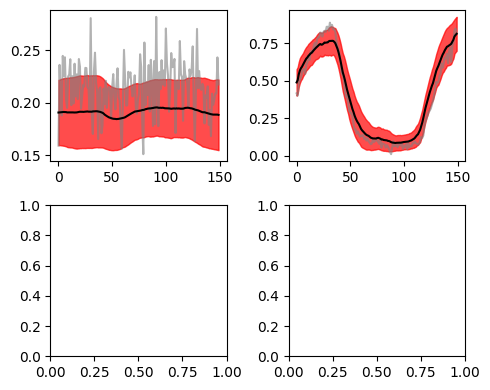

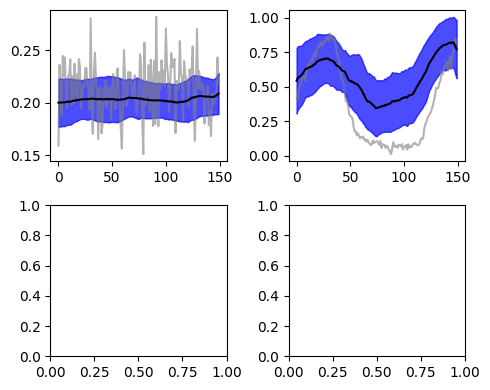

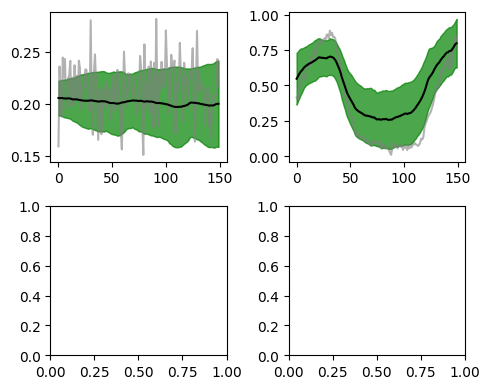

In [44]:
## Plotting ave and std TEST
#HIGH

fig, ax = plt.subplots(2,2, figsize = (5,4))
for k in range(2):
    if k < 5:
        ax[0,k].plot(test_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[0,k].plot(test_ave_high[n_loc[k]], color = 'black')
        high = test_ave_high[n_loc[k]] + test_std_high[n_loc[k]]
        low = test_ave_high[n_loc[k]] - test_std_high[n_loc[k]]
        ax[0,k].fill_between(np.arange(test_std_high[0].shape[0]), low, high, color = 'red', alpha =0.7)

  
    if k >= 5:
        ax[1,k-5].plot(test_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[1,k-5].plot(test_ave_high[n_loc[k]], color = 'black')
        high = test_ave_high[n_loc[k]] + test_std_high[n_loc[k]]
        low = test_ave_high[n_loc[k]] - test_std_high[n_loc[k]]
        ax[1,k-5].fill_between(np.arange(test_std_high[0].shape[0]), low, high, color = 'red', alpha =0.7)

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/high_trace.png", transparent=True, dpi=500)
plt.show()


#LOW
fig, ax = plt.subplots(2,2, figsize = (5,4))
for k in range(2):
    if k < 5:
        ax[0,k].plot(test_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[0,k].plot(test_ave_low[n_loc[k]], color = 'black')
        high = test_ave_low[n_loc[k]] + test_std_low[n_loc[k]]
        low = test_ave_low[n_loc[k]] - test_std_low[n_loc[k]]
        ax[0,k].fill_between(np.arange(test_std_low[0].shape[0]), low, high, color = 'blue', alpha =0.7)

  
    # if k >= 5:
    #     ax[1,k-5].plot(test_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
    #     ax[1,k-5].plot(test_ave_low[n_loc[k]], color = 'black')
    #     high = test_ave_low[n_loc[k]] + test_std_low[n_loc[k]]
    #     low = test_ave_low[n_loc[k]] - test_std_low[n_loc[k]]
    #     ax[1,k-5].fill_between(np.arange(test_std_low[0].shape[0]), low, high, color = 'blue', alpha =0.7)

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/low_trace.png", transparent=True, dpi=500)

plt.show()


#Rand
fig, ax = plt.subplots(2,2, figsize = (5,4))
for k in range(2):
    if k < 5:
        ax[0,k].plot(test_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[0,k].plot(test_ave_rand[n_loc[k]], color = 'black')
        high = test_ave_rand[n_loc[k]] + test_std_rand[n_loc[k]]
        low = test_ave_rand[n_loc[k]] - test_std_rand[n_loc[k]]
        ax[0,k].fill_between(np.arange(test_std_rand[0].shape[0]), low, high, color = 'green', alpha =0.7)

  
    if k >= 5:
        ax[1,k-5].plot(test_gt[0][:,n_loc[k]], color = 'grey', alpha = 0.6)
        ax[1,k-5].plot(test_ave_rand[n_loc[k]], color = 'black')
        high = test_ave_rand[n_loc[k]] + test_std_rand[n_loc[k]]
        low = test_ave_rand[n_loc[k]] - test_std_rand[n_loc[k]]
        ax[1,k-5].fill_between(np.arange(test_std_rand[0].shape[0]), low, high, color = 'green', alpha =0.7)

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/rand_trace.png", transparent=True, dpi=500)

plt.show()

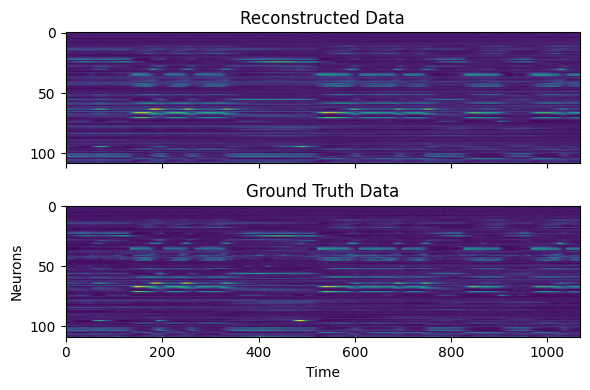

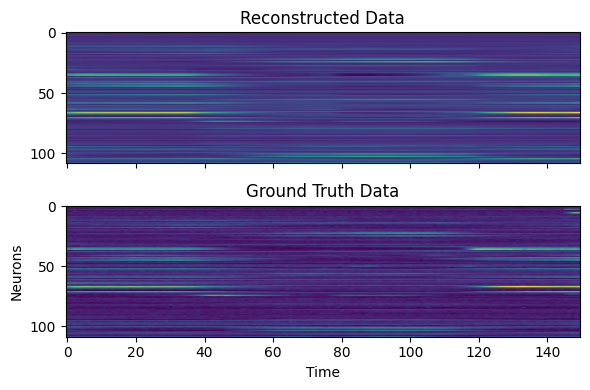

In [ ]:
### Plotting reconstructions carpet plots-- Training Dataset

### Reconstructed and ground truth Carpet Plot
fig, axes = plt.subplots(2, figsize=(6, 4), sharex=True, sharey=True)
# Plot the reconstructed data
axes[0].imshow(train_recon_high[10].T, aspect='auto')
axes[0].set_title("Reconstructed Data")
# Plot the ground truth data
axes[1].imshow(train_gt[10].T, aspect='auto')
axes[1].set_title("Ground Truth Data")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Neurons')

plt.tight_layout()
plt.show()


### Plotting reconstructions carpet plots-- Testing Dataset

### Reconstructed and ground truth Carpet Plot
fig, axes = plt.subplots(2, figsize=(6, 4), sharex=True, sharey=True)
# Plot the reconstructed data
axes[0].imshow(test_recon_high[10].T, aspect='auto')
axes[0].set_title("Reconstructed Data")
# Plot the ground truth data
axes[1].imshow(test_gt[10].T, aspect='auto')
axes[1].set_title("Ground Truth Data")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Neurons')

plt.tight_layout()
plt.show()



In [ ]:

# ### Reconstructed and ground truth Activity Traces - selected neurons
# fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
# for i in range(num_neurons):
#     axes[i].plot(test_recons[:, neuron_locations[i]], label = "Reconstructed Data", color = 'red')
#     axes[i].plot(test_ground_truth[:, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
#     axes[1].set_title('Neurons Selected')
# plt.legend()
# plt.tight_layout()
# plt.show()


# ### Reconstructed and ground truth Activity Traces - random neurons
# neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
# fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
# for i in range(5):
#     axes[i].plot(test_recons[:, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
#     axes[i].plot(test_ground_truth[:, neuron_loc_graph[i]], label = 'Ground Truth Data', color ='grey')
#     axes[2].set_title('Neurons Randomly Selected')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:

plt.scatter(np.arange(1,26), train_mse_high)
plt.scatter(np.arange(1,26), train_mse_low)
plt.scatter(np.arange(1,26), train_mse_rand)

plt.title('Train MSE')
plt.show()


plt.scatter(np.arange(1,26), test_mse_high)
plt.scatter(np.arange(1,26), test_mse_low)
plt.scatter(np.arange(1,26), test_mse_rand)

plt.title('Test MSE')
plt.show()
